# NFL Prediction

### Fall 2025 Data Science Project

Andrew Weil, Corey Gross, Kai Fosshage, Ben Scrivanich, Allison Bejeck, Stephen Griffin


# 1) Contributions


For each member, list which of the following sections they worked on, and
summarize the contributions in 1-2 sentences. Be specific!

A: Project idea

B: Dataset Curation and Preprocessing

C: Data Exploration and Summary Statistics

D: ML Algorithm Design/Development

E: ML Algorithm Training and Test Data Analysis

F: Visualization, Result Analysis, Conclusion

G: Final Tutorial Report Creation

H: Additional (not listed above)




| Member          | Sections | Summary |
|-----------------|:----------|:---------|
| Andrew Weil     |           |         |
| Corey Gross     |           |         |
| Kai Fosshage    |           |         |
| Ben Scrivanich  |           |         |
| Allison Bejeck  |           |         |
| Stephen Griffin  |           |         |

# 2) Introduction


For our project, we decided to make a model that uses a combination of pre and in-game features to predict the outcome of NFL matchups. Essentially, we are trying to determine which team will win a football game as it is unfolding, not just beforehand. The questions we are trying to answer in our analysis are which factors are the most effective at predicting the game results. By identifying which pieces of data are most influential during the game, our model can highlight trends or key performance indicators that matter the most. This insight could help players, coaches, or analysts make more informed decisions in real time and better understand how specific events impact the final result.

# 3) Data Curation


For this project we used nflreadr, which contains play by play data on NFL games since 1999. It is a package within the wider nflverse, created by five individual contributors - Sebastian Carl, Ben Baldwin, Lee Sharpe, Tan Ho, and John Edwards.

Carl S., & Baldwin B., & Sharpe L., & Ho T., & Edwards J. (2020). NFLVERSE

[nflverse.com](https://www.nflverse.com)


***MAKE SURE TO INCLUDE pip install nflreadpy

*check previous example [HERE](https://shahsean.github.io/)

# 4) Exploratory data analysis


In [ ]:
import pandas as pd
import numpy as np
import nflreadpy as nfl
from statsmodels.stats.proportion import proportions_ztest

try:
    print("Loading play-by-play data...")
    pbp_data = nfl.load_pbp(seasons=range(2002, 2025)).to_pandas()
    print(f"Loaded {len(pbp_data):,} play-by-play records")

    print("Loading schedules data...")
    schedules_data = nfl.load_schedules(seasons=range(2002, 2024)).to_pandas()
    print(f"Loaded {len(schedules_data):,} schedule records")

    print("Data loading complete!")

except Exception as e:
    print(f"Error loading data: {e}")


Loading play-by-play data...


Downloading: 100%|██████████| 14.8M/14.8M [00:02<00:00, 6.72MB/s]


Downloading: 100%|██████████| 14.6M/14.6M [00:01<00:00, 9.46MB/s]


Downloading: 100%|██████████| 14.6M/14.6M [00:01<00:00, 8.94MB/s]


Downloading: 100%|██████████| 14.6M/14.6M [00:01<00:00, 11.1MB/s]


Downloading: 100%|██████████| 18.6M/18.6M [00:02<00:00, 6.33MB/s]


Downloading: 100%|██████████| 18.7M/18.7M [00:03<00:00, 5.98MB/s]


Downloading: 100%|██████████| 18.6M/18.6M [00:04<00:00, 3.97MB/s]


Downloading: 100%|██████████| 18.9M/18.9M [00:03<00:00, 5.33MB/s]


Downloading: 100%|██████████| 19.1M/19.1M [00:03<00:00, 5.05MB/s]


Downloading: 100%|██████████| 19.1M/19.1M [00:03<00:00, 5.36MB/s]


Downloading: 100%|██████████| 19.3M/19.3M [00:04<00:00, 4.54MB/s]


Downloading: 100%|██████████| 19.5M/19.5M [00:04<00:00, 4.80MB/s]


Downloading:  81%|████████  | 15.6M/19.4M [00:02<00:00, 5.56MB/s]


KeyboardInterrupt: 

In [ ]:
print("Filtering play-by-play data to regular season games...")
# Filter to regular season games only
pbp_reg = pbp_data[pbp_data['season_type'] == 'REG'].copy()
# Remove rows with null or invalid game_id
pbp_reg = pbp_reg.dropna(subset=['game_id'])
print(f"After filtering: {len(pbp_reg):,} regular season play records")

# Filter schedules to regular season games only
schedules_reg = schedules_data[schedules_data['game_type'] == 'REG'].copy()
print(f"Regular season games before cleaning: {len(schedules_reg):,}")

# Remove any rows with null scores first
schedules_reg = schedules_reg.dropna(subset=['home_score', 'away_score'])
print(f"After removing null scores: {len(schedules_reg):,}")

# Remove tie games (where home_score == away_score)
# Ties don't fit binary win/loss classification
ties_removed = schedules_reg[schedules_reg['home_score'] == schedules_reg['away_score']]
print(f"Tie games found and removed: {len(ties_removed)}")

schedules_reg = schedules_reg[schedules_reg['home_score'] != schedules_reg['away_score']].copy()
print(f"Final regular season games (no ties): {len(schedules_reg):,}")

print("Data filtering complete!")

Filtering play-by-play data to regular season games...
After filtering: 1,047,916 regular season play records
Regular season games before cleaning: 5,679
After removing null scores: 5,679
Tie games found and removed: 14
Final regular season games (no ties): 5,665
Data filtering complete!


In [ ]:
# Single aggregation for all offensive stats by game and team
offensive_features = pbp_reg.groupby(['game_id', 'posteam']).agg({
    # First downs - any play that resulted in a first down
    'first_down': lambda x: (x == 1).sum(),
    # Passing yards - sum all passing yards (includes negative sack yards)
    'passing_yards': lambda x: x.fillna(0).sum(),
    # Rushing yards - sum all rushing yards
    'rushing_yards': lambda x: x.fillna(0).sum(),
    # Turnovers lost
    'fumble_lost': lambda x: (x == 1).sum(),
    'interception': lambda x: (x == 1).sum()
}).reset_index()

offensive_features['off_1st_down'] = offensive_features['first_down']
offensive_features['off_pass_yds'] = offensive_features['passing_yards']
offensive_features['off_rush_yds'] = offensive_features['rushing_yards']
offensive_features['off_turnovers'] = offensive_features['fumble_lost'] + offensive_features['interception']
offensive_features['off_total_yds'] = offensive_features['off_pass_yds'] + offensive_features['off_rush_yds']

# Keep only the final columns we need
offensive_features = offensive_features[['game_id', 'posteam', 'off_1st_down', 'off_pass_yds',
                                       'off_rush_yds', 'off_total_yds', 'off_turnovers']]

# Fill any remaining NaN values with 0
offensive_features = offensive_features.fillna(0)

print(f"Offensive features calculated for {len(offensive_features):,} team-game combinations")
print(offensive_features.head())

Offensive features calculated for 11,902 team-game combinations
           game_id posteam  off_1st_down  off_pass_yds  off_rush_yds  \
0  2002_01_ARI_WAS     ARI            14         187.0          70.0   
1  2002_01_ARI_WAS     WAS            21         327.0         122.0   
2   2002_01_ATL_GB     ATL            22         209.0         180.0   
3   2002_01_ATL_GB      GB            29         284.0         211.0   
4  2002_01_BAL_CAR     BAL            15         218.0          77.0   

   off_total_yds  off_turnovers  
0          257.0              1  
1          449.0              1  
2          389.0              1  
3          495.0              1  
4          295.0              1  


In [ ]:
team_mapping = {
    'SD': 'LAC',   # Los Angeles Chargers : San Diego Chargers
    'OAK': 'LV',   # Las Vegas Raiders : Oakland Raiders
    'STL': 'LA'    # Los Angeles Rams : St. Louis Rams
}

offensive_features['posteam'] = offensive_features['posteam'].replace(team_mapping)
print(f"Mapping applied to {len(offensive_features):,} offensive feature records")

schedules_reg['home_team'] = schedules_reg['home_team'].replace(team_mapping)
schedules_reg['away_team'] = schedules_reg['away_team'].replace(team_mapping)
print(f"Mapping applied to schedules: {schedules_reg['home_team'].nunique()} unique teams")

all_offensive_teams = set(offensive_features['posteam'].unique())
all_schedule_teams = set(schedules_reg['home_team'].unique()) | set(schedules_reg['away_team'].unique())
print(f"\nVerification:")
print(f"  Teams in offensive features: {len(all_offensive_teams)}")
print(f"  Teams in schedules: {len(all_schedule_teams)}")

Mapping applied to 11,902 offensive feature records
Mapping applied to schedules: 32 unique teams

Verification:
  Teams in offensive features: 32
  Teams in schedules: 32


In [ ]:
# Create a copy of offensive features to transform into defensive features
defensive_features = offensive_features.copy()


home_mapping = schedules_reg[['game_id', 'home_team', 'away_team']].rename(columns={
    'home_team': 'posteam', 'away_team': 'opponent'
})
away_mapping = schedules_reg[['game_id', 'away_team', 'home_team']].rename(columns={
    'away_team': 'posteam', 'home_team': 'opponent'
})

team_opponent_mapping = pd.concat([home_mapping, away_mapping], ignore_index=True)

offensive_with_opponents = offensive_features.merge(
    team_opponent_mapping,
    on=['game_id', 'posteam'],
    how='left'
)

# Create defensive features: Team A's defensive stats = Team B's offensive stats

defensive_features = offensive_with_opponents.copy()
defensive_features['team'] = defensive_features['opponent']  # The team we're calculating defense for
defensive_features = defensive_features.drop(['posteam', 'opponent'], axis=1)
defensive_features = defensive_features.rename(columns={'team': 'posteam'})

defensive_features = defensive_features.rename(columns={
    'off_1st_down': 'def_1st_down',
    'off_pass_yds': 'def_pass_yds',
    'off_rush_yds': 'def_rush_yds',
    'off_total_yds': 'def_total_yds',
    'off_turnovers': 'def_turnovers'
})

defensive_features.head()

,game_id,def_1st_down,def_pass_yds,def_rush_yds,def_total_yds,def_turnovers,posteam
0,2002_01_ARI_WAS,14,187.0,70.0,257.0,1,WAS
1,2002_01_ARI_WAS,21,327.0,122.0,449.0,1,ARI
2,2002_01_ATL_GB,22,209.0,180.0,389.0,1,GB
3,2002_01_ATL_GB,29,284.0,211.0,495.0,1,ATL
4,2002_01_BAL_CAR,15,218.0,77.0,295.0,1,CAR


In [ ]:

print("Merging offensive and defensive features...")


combined_features = offensive_features.merge(
    defensive_features[['game_id', 'posteam', 'def_1st_down',
                       'def_pass_yds', 'def_rush_yds', 'def_total_yds', 'def_turnovers']],
    on=['game_id', 'posteam'],
    how='left'
)

print(f"Combined features dataset: {len(combined_features):,} team-game combinations")
combined_features.head()

Merging offensive and defensive features...
Combined features dataset: 11,902 team-game combinations


,game_id,posteam,off_1st_down,off_pass_yds,off_rush_yds,off_total_yds,off_turnovers,def_1st_down,def_pass_yds,def_rush_yds,def_total_yds,def_turnovers
0,2002_01_ARI_WAS,ARI,14,187.0,70.0,257.0,1,21.0,327.0,122.0,449.0,1.0
1,2002_01_ARI_WAS,WAS,21,327.0,122.0,449.0,1,14.0,187.0,70.0,257.0,1.0
2,2002_01_ATL_GB,ATL,22,209.0,180.0,389.0,1,29.0,284.0,211.0,495.0,1.0
3,2002_01_ATL_GB,GB,29,284.0,211.0,495.0,1,22.0,209.0,180.0,389.0,1.0
4,2002_01_BAL_CAR,BAL,15,218.0,77.0,295.0,1,15.0,136.0,145.0,281.0,0.0


In [ ]:
# Create separate dataframes for home and away teams with their scores
home_teams = schedules_reg[['game_id', 'season', 'week', 'gameday',
'home_team', 'home_score', 'away_score', 'overtime']].rename(columns={
    'home_team': 'posteam',
    'home_score': 'tm_score',
    'away_score': 'opp_score',
    'overtime': 'overtime'
})
home_teams['home'] = 1

away_teams = schedules_reg[['game_id', 'season', 'week', 'gameday',
'away_team', 'away_score', 'home_score', 'overtime']].rename(columns={
    'away_team': 'posteam',
    'away_score': 'tm_score',
    'home_score': 'opp_score',
    'overtime': 'overtime'
})
away_teams['home'] = 0

# Combine home and away team data
game_context = pd.concat([home_teams, away_teams], ignore_index=True)

# Merge combined features with game context
final_features = combined_features.merge(
    game_context,
    on=['game_id', 'posteam'],
    how='left'
)

missing_context_after = final_features['season'].isnull().sum()
print(f"Records still missing context: {missing_context_after}")

final_features.head()

Records still missing context: 572


,game_id,posteam,off_1st_down,off_pass_yds,off_rush_yds,off_total_yds,off_turnovers,def_1st_down,def_pass_yds,def_rush_yds,def_total_yds,def_turnovers,season,week,gameday,tm_score,opp_score,overtime,home
0,2002_01_ARI_WAS,ARI,14,187.0,70.0,257.0,1,21.0,327.0,122.0,449.0,1.0,2002.0,1.0,2002-09-08,23.0,31.0,0.0,0.0
1,2002_01_ARI_WAS,WAS,21,327.0,122.0,449.0,1,14.0,187.0,70.0,257.0,1.0,2002.0,1.0,2002-09-08,31.0,23.0,0.0,1.0
2,2002_01_ATL_GB,ATL,22,209.0,180.0,389.0,1,29.0,284.0,211.0,495.0,1.0,2002.0,1.0,2002-09-08,34.0,37.0,1.0,0.0
3,2002_01_ATL_GB,GB,29,284.0,211.0,495.0,1,22.0,209.0,180.0,389.0,1.0,2002.0,1.0,2002-09-08,37.0,34.0,1.0,1.0
4,2002_01_BAL_CAR,BAL,15,218.0,77.0,295.0,1,15.0,136.0,145.0,281.0,0.0,2002.0,1.0,2002-09-08,7.0,10.0,0.0,0.0


In [ ]:
# Remove records with missing context data first (these can't have wins/losses calculated)
clean_features = final_features.dropna(subset=['season', 'week', 'tm_score', 'opp_score']).copy()
print(f"Removed records with missing context, {len(clean_features):,} records remaining")

# Remove any invalid team entries
clean_features = clean_features[clean_features['posteam'] != 0].copy()
print(f"Removed invalid team entries, {len(clean_features):,} records remaining")

# Create win indicator
clean_features['won'] = (clean_features['tm_score'] > clean_features['opp_score']).astype(int)

clean_features['wins'] = 0
clean_features['losses'] = 0

# Calculate running wins and losses for each team in each season
for team in clean_features['posteam'].unique():
    if pd.isna(team):  # Skip any NaN teams
        continue
    for season in clean_features['season'].unique():
        if pd.isna(season):  # Skip any NaN seasons
            continue
        mask = (clean_features['posteam'] == team) & (clean_features['season'] == season)
        team_season_games = clean_features[mask].copy()

        if len(team_season_games) > 0:
            team_season_games = team_season_games.sort_values(['week', 'gameday', 'game_id'])

            wins_so_far = team_season_games['won'].shift(1).fillna(0).cumsum()
            losses_so_far = (1 - team_season_games['won']).shift(1).fillna(0).cumsum()

            clean_features.loc[team_season_games.index, 'wins'] = wins_so_far.astype(int)
            clean_features.loc[team_season_games.index, 'losses'] = losses_so_far.astype(int)


clean_features[['posteam', 'season', 'week', 'tm_score', 'opp_score', 'won', 'wins', 'losses', 'overtime']].head(10)

Removed records with missing context, 11,330 records remaining
Removed invalid team entries, 11,330 records remaining


,posteam,season,week,tm_score,opp_score,won,wins,losses,overtime
0,ARI,2002.0,1.0,23.0,31.0,0,0,0,0.0
1,WAS,2002.0,1.0,31.0,23.0,1,0,0,0.0
2,ATL,2002.0,1.0,34.0,37.0,0,0,0,1.0
3,GB,2002.0,1.0,37.0,34.0,1,0,0,1.0
4,BAL,2002.0,1.0,7.0,10.0,0,0,0,0.0
5,CAR,2002.0,1.0,10.0,7.0,1,0,0,0.0
6,DAL,2002.0,1.0,10.0,19.0,0,0,0,0.0
7,HOU,2002.0,1.0,19.0,10.0,1,0,0,0.0
8,DET,2002.0,1.0,21.0,49.0,0,0,0,0.0
9,MIA,2002.0,1.0,49.0,21.0,1,0,0,0.0


In [ ]:
clean_features['outcome'] = clean_features['won']



all_columns = [
    'game_id', 'posteam', 'season', 'week', 'overtime',
    'off_1st_down', 'off_pass_yds', 'off_rush_yds', 'off_total_yds', 'off_turnovers',
    'def_1st_down', 'def_pass_yds', 'def_rush_yds', 'def_total_yds', 'def_turnovers',
    'tm_score', 'opp_score', 'home', 'wins', 'losses', 'outcome'
]


# Select only the features we need for modeling
model_features = clean_features[all_columns].copy()


model_features.head()
model_features.to_csv('nfl_game_features_2002_2024.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

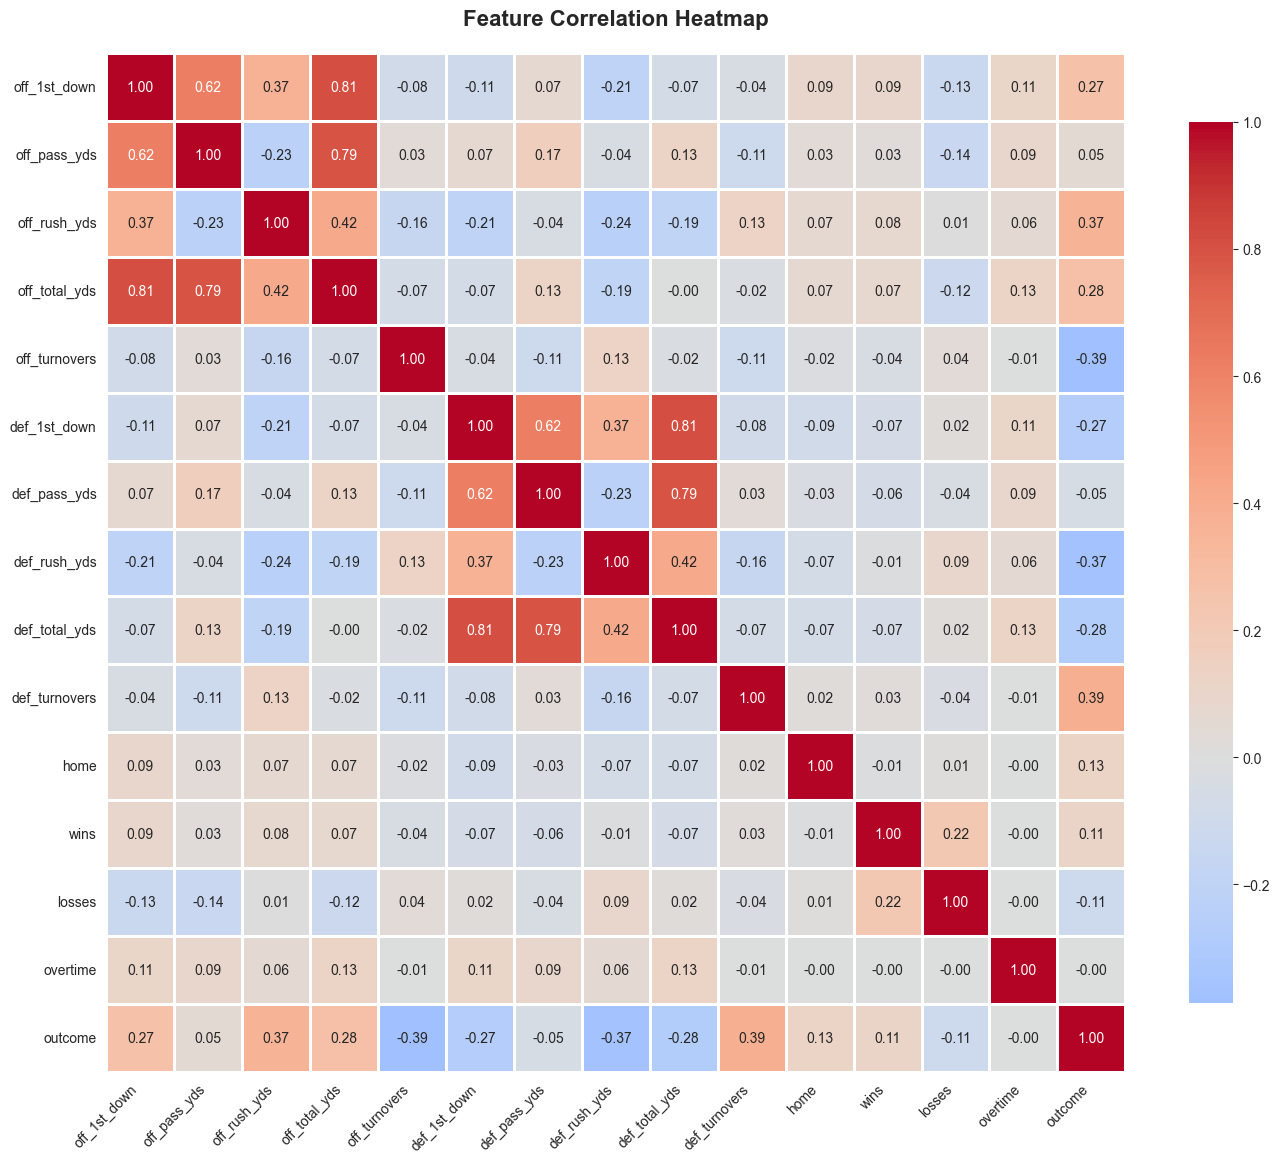


Strongest correlations with game outcome (win/loss):
def_turnovers    3.866663e-01
off_rush_yds     3.660353e-01
off_total_yds    2.759806e-01
off_1st_down     2.711325e-01
home             1.269197e-01
wins             1.116975e-01
off_pass_yds     4.865839e-02
overtime        -3.410252e-17
def_pass_yds    -4.865839e-02
losses          -1.120622e-01
def_1st_down    -2.711325e-01
def_total_yds   -2.759806e-01
def_rush_yds    -3.660353e-01
off_turnovers   -3.866663e-01
Name: outcome, dtype: float64


In [ ]:
numeric_features = ['off_1st_down', 'off_pass_yds', 'off_rush_yds', 'off_total_yds', 'off_turnovers',
                   'def_1st_down', 'def_pass_yds', 'def_rush_yds', 'def_total_yds', 'def_turnovers',
                   'home', 'wins', 'losses', 'overtime', 'outcome']

correlation_matrix = model_features[numeric_features].corr()

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nStrongest correlations with game outcome (win/loss):")
outcome_corr = correlation_matrix['outcome'].sort_values(ascending=False)
print(outcome_corr[outcome_corr.index != 'outcome'])

**Hypothesis Testing** - Home Field Advantage during regular season, Statistical method ONE

*Along with the questions above, here is the hypothesis testing

H0: The probability of the home team winning is equal to 50% (no home-field advantage)

Ha: The probability of the home team winning is greater than 50% (home-field advantage exists).

**Statistical test for result**: The goal is to see how many games were won by the home team versus the away team to test whether or not there is a home-field advantage. We will use the Z-test because of the binary outcome (win or loss) and the sample size of data (around 272 games played in a regular season of the NFL)

We will be computing the z-test for each season and for all regular season games in the past five years in order to see the general effect and variability over time

Home teams win 53.2% of games

Home win rate by season:
  2020: 49.6%
  2021: 51.5%
  2022: 55.7%
  2023: 55.5%
  2024: 53.3%

Average home field advantage: 1.7 points

 Total games and wins by season:
    season  season_home_wins  season_total_games
1    2021               140                 272
2    2022               151                 271
3    2023               151                 272
4    2024               145                 272

Season 2021: 'z_score': 0.4853, 'p_value': 0.3137
P-value is greater than alpha, fail to reject null hypothesis
There is not enough evidence to conclude that the average home win rate is greater than 50%.


Season 2022: 'z_score': 1.8956, 'p_value': 0.0290
P-value is less than alpha,reject null hypothesis
The average home win rate is significantly greater than 50%.


Season 2023: 'z_score': 1.8302, 'p_value': 0.0336
P-value is less than alpha,reject null hypothesis
The average home win rate is significantly greater than 50%.


Season 2024: 'z_score':

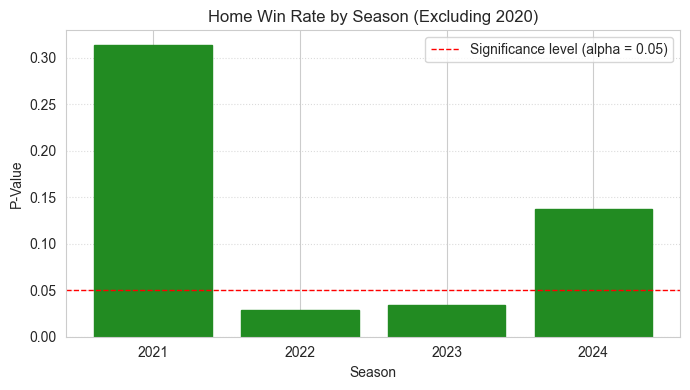

Z-Test for all regular season games in the completed_games dataset (excluding 2020):

Z-statistic: 2.6473
P-value: 0.0041
Conclusion: P-value less than alpha value, Reject the null hypothesis.

The average home win rate is significantly greater than 50%.


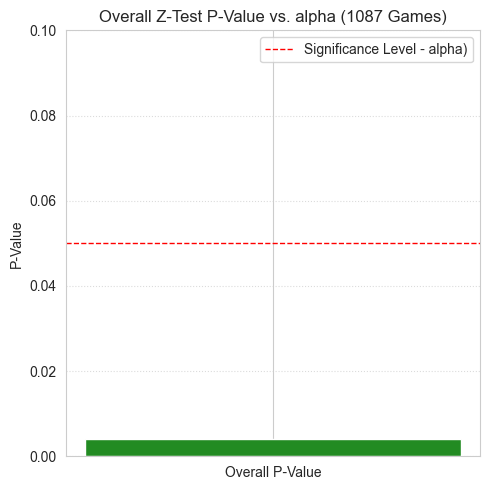

In [ ]:
z_seasons = [2020, 2021, 2022, 2023, 2024]
z_schedules = nfl.load_schedules(z_seasons)

games_df = z_schedules.to_pandas()

# Filter to reg szn only
completed_games = games_df[games_df['game_type'] == 'REG'].copy()
completed_games = completed_games[~completed_games['home_score'].isna()].copy()

if len(completed_games) > 0:
    # Calculate basic home field advantage
    completed_games['home_win'] = (completed_games['home_score'] > completed_games['away_score']).astype(int)

    home_win_rate = completed_games['home_win'].mean()
    print(f"Home teams win {home_win_rate:.1%} of games")

    # By season
    print(f"\nHome win rate by season:")
    season_home_wins = completed_games.groupby('season')['home_win'].mean()

    for season, win_rate in season_home_wins.items():
        print(f"  {season}: {win_rate:.1%}")


    # Calculate point differentials
    completed_games['point_diff'] = completed_games['home_score'] - completed_games['away_score']
    avg_home_advantage = completed_games['point_diff'].mean()
    print(f"\nAverage home field advantage: {avg_home_advantage:.1f} points")

    #Z-Test by Season
    # to keep track of data for table:
    season_res_chart = []
    #group by season with the total of home wins and total games for the season
    season_count = completed_games.groupby('season').agg(
        season_home_wins =('home_win', 'sum'),
        season_total_games = ('home_win', 'count')
    ).reset_index()
    #excluding 2020 season as a factor, COVID games had no fans
    season_count = season_count[season_count['season'] != 2020]
    print(f"\n Total games and wins by season:\n {season_count}")
    for row in season_count.itertuples():
      nobs=row[3]
      count=row[2]
      season=row[1]
      z_stat, p_value = proportions_ztest(count=count, nobs=nobs, value=0.5, alternative='larger')
      print(f"\nSeason {season}: 'z_score': {z_stat:.4f}, 'p_value': {p_value:.4f}")
      season_res_chart.append({'Season': str(season),
        'Observed Win Rate': count / nobs,
        'P-Value (one-sided)': p_value,
        'Home Wins': count,
        'Total Games': nobs})

      alpha = 0.05
      if p_value <= alpha:
        print("P-value is less than alpha,reject null hypothesis")
        print("The average home win rate is significantly greater than 50%.\n")
      else:
        print("P-value is greater than alpha, fail to reject null hypothesis")
        print("There is not enough evidence to conclude that the average home win rate is greater than 50%.\n")

##plot for first Z-test
    seasonal_df = pd.DataFrame(season_res_chart)
    plt.figure(figsize=(7, 4))
    bars = plt.bar(seasonal_df['Season'], seasonal_df['P-Value (one-sided)'])
    plt.axhline(0.05, color='red', linestyle='--', linewidth=1, label='Significance level (alpha = 0.05)')

    for bar in bars:
        bar.set_color('forestgreen')

    plt.title('Home Win Rate by Season (Excluding 2020)')
    plt.ylabel('P-Value')
    plt.xlabel('Season')
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()


     # Z-test Statistic for all regular season games:
    print("Z-Test for all regular season games in the completed_games dataset (excluding 2020):")
    updated_completed_games = completed_games[completed_games['season'] != 2020]
    total_home_wins= updated_completed_games['home_win'].sum().astype(int)
    n_games = updated_completed_games['home_win'].count().astype(int)
    z_stat, p_value = proportions_ztest(count=total_home_wins, nobs=n_games, value=0.5, alternative='larger')
    print(f"\nZ-statistic: {z_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    alpha = 0.05
    if p_value <= alpha:
      print("Conclusion: P-value less than alpha value, Reject the null hypothesis.")
      print("\nThe average home win rate is significantly greater than 50%.")
    else:
      print("Conclusion: P-value greater than alpha value, Fail to reject the null hypothesis.")
      print("\nThere is not enough evidence to conclude that the average home win rate is greater than 50%.")

    #Graph for second z-test for all season games (combined seasons)
    plt.figure(figsize=(5, 5))
    # Plot single bar to represent the p-value
    plt.bar(['Overall P-Value'], [p_value],
        color='forestgreen' ,
        width=0.5)

    #line for alpha
    plt.axhline(alpha, color='red', linestyle='--', linewidth=1, label=r'Significance Level - alpha)')

    plt.title(f'Overall Z-Test P-Value vs. alpha ({n_games} Games)')
    plt.ylabel('P-Value')
    plt.ylim(0, 0.1)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No completed games found in dataset")

**Z-Test results/Conclusions**

**Z-Test by Season**
The 2021 and 2024 season both fail to reject the null hypothesis, and the 2022 and 2023 season reject the null hypothesis.

The difference in these results suggest that home-field advantage may vary from year to year, because of its sensitivity to external factors (like COVID)

**Z-Test, combining multiple seasons**
Despite the fluctuations in the individual seasons, the combined data supports that nfl home teams won more than 50% of their games, indicating a robust overall home-field advantage.

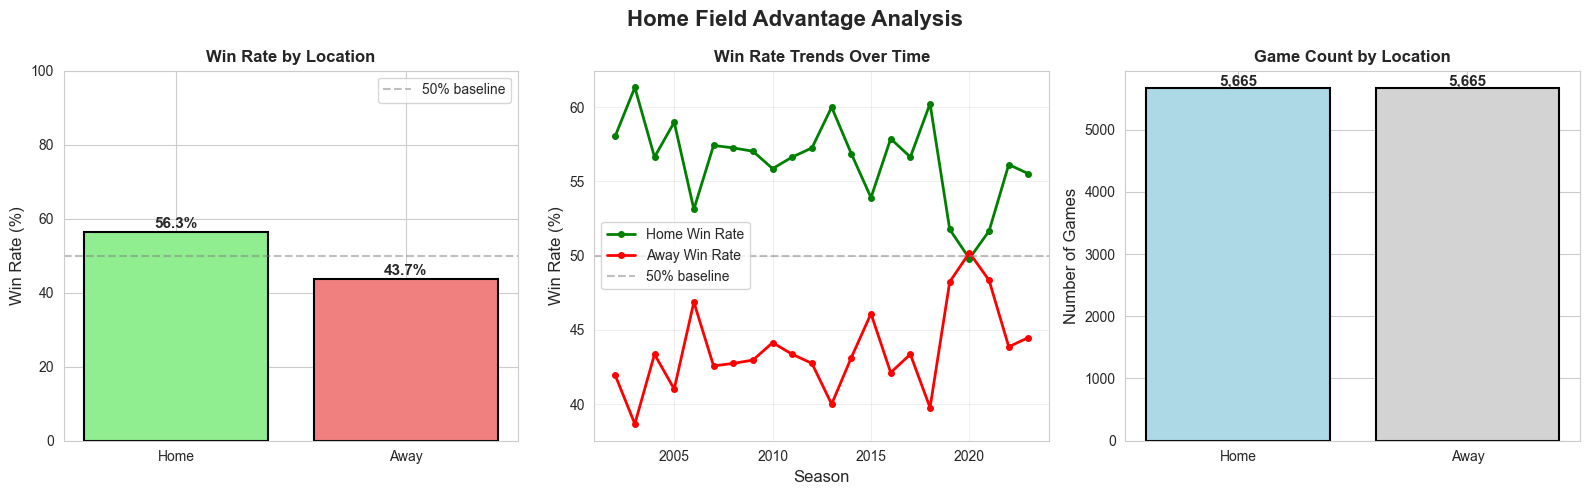


=== Home Field Advantage Statistics ===
Home Win Rate: 56.35% (3,192 wins out of 5,665 games)
Away Win Rate: 43.65% (2,473 wins out of 5,665 games)
Home Field Advantage: 12.69 percentage points


In [ ]:
home_games = model_features[model_features['home'] == 1]
away_games = model_features[model_features['home'] == 0]

home_win_rate = home_games['outcome'].mean()
away_win_rate = away_games['outcome'].mean()

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Home Field Advantage Analysis', fontsize=16, fontweight='bold')

# 1. Win rate comparison
ax1 = axes[0]
locations = ['Home', 'Away']
win_rates = [home_win_rate * 100, away_win_rate * 100]
colors = ['lightgreen', 'lightcoral']
bars = ax1.bar(locations, win_rates, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Win Rate (%)', fontsize=12)
ax1.set_title('Win Rate by Location', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.axhline(50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
ax1.legend()

# Add percentage labels on bars
for i, (bar, rate) in enumerate(zip(bars, win_rates)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

# 2. Win rate over seasons
ax2 = axes[1]
home_by_season = model_features[model_features['home'] == 1].groupby('season')['outcome'].mean() * 100
away_by_season = model_features[model_features['home'] == 0].groupby('season')['outcome'].mean() * 100

ax2.plot(home_by_season.index, home_by_season.values, 'o-', color='green',
         label='Home Win Rate', linewidth=2, markersize=4)
ax2.plot(away_by_season.index, away_by_season.values, 'o-', color='red',
         label='Away Win Rate', linewidth=2, markersize=4)
ax2.axhline(50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
ax2.set_xlabel('Season', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_title('Win Rate Trends Over Time', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Count of games
ax3 = axes[2]
game_counts = [len(home_games), len(away_games)]
bars = ax3.bar(locations, game_counts, color=['lightblue', 'lightgray'],
               edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Number of Games', fontsize=12)
ax3.set_title('Game Count by Location', fontsize=12, fontweight='bold')

# Add count labels on bars
for bar, count in zip(bars, game_counts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== Home Field Advantage Statistics ===")
print(f"Home Win Rate: {home_win_rate*100:.2f}% ({home_games['outcome'].sum():,} wins out of {len(home_games):,} games)")
print(f"Away Win Rate: {away_win_rate*100:.2f}% ({away_games['outcome'].sum():,} wins out of {len(away_games):,} games)")
print(f"Home Field Advantage: {(home_win_rate - away_win_rate)*100:.2f} percentage points")

# Dataset Analysis Conclusion

## **Dataset Overview**
This NFL game outcome dataset contains 11,330 team-game records spanning from the 2002 to 2024 regular seasons The dataset contains 21 features organized into four main categories: identifiers (game_id, posteam, season, week), offensive statistics (5 features), defensive statistics (5 features), game context (4 features), and the target variable (outcome). After cleaning, the dataset represents 5,665 complete games with 32 unique NFL teams, maintaining a balanced structure where each game generates two records.

## **Feature Characteristics and Distribution**
The dataset exhibits good balance with exactly 50% wins and 50% losses across all records, as expected from the paired nature of game outcomes. However, a signifiant home field advantage is evident in the data: home teams win 56.35% of games (3,192 wins) compared to away teams' 43.65% (2,473 wins), representing a substantial 12.69 percentage point advantage. This home field advantage has remained relatively consistent across all 23 seasons analyzed, showing minimal variance over time, which suggests it is a stable and persistent factor in NFL outcomes.

## **Feature Correlations and Predictive Importance**
The correlation analysis reveals several insights about feature relationships and their ability to predict game outcomes:

##### **Strongest Positive Predictors:**

Defensive turnovers forced (0.387)
Offensive rushing yards (0.366)
Offensive total yards (0.276)
Offensive first downs (0.271)
Home field advantage (0.127)

##### **Strongest Negative Predictors:**

Offensive turnovers committed (-0.387)
Defensive rushing yards allowed (-0.366)
Defensive total yards allowed (-0.276)
Defensive first downs allowed (-0.271)

# 5) Primary Analysis
After exploring the dataset and identifying patterns within, the next step is to apply a machine learning technique that can address our core concern:
Can we predict the outcome of an NFL game using features available before kickoff and features that change throughout the course of the game?

To answer this, we assessed multiple potential modeling approaches. Eventually, we came to the conclusion that Logistic Regression should be the model we select. This is not only due to its performance, but also its suitability for a time dependent sport like football.

### Why Classification?
Since our outcome is binary (win or loss), classification is the most natural modeling technique that could apply. A regression model predicting point differential could be used, but this involves unnecessary complexity. Classification directly learns the boundary between a win and a loss, allowing us to estimate a win in real time.

### Evaluating Models
We selected Logistic Regression for a number of reasons:

1. **Interpretability**
For sports analytics, its important to be able to explain why a model increases or decreases a team's win probability. It might even be as important as the prediction itself.

2. **Outputs Probabilities**
Unlike many models, logistic regression produces smooth probability estimates.

3. **Handles Linear Relationships Well**
Features like score differential and time remaining have a predictable effect. The more a team leads, the higher their chances of winning. The less time remaining, the harder it is for the trailing team to catch up.

4. **Performs well on large datasets**
Play by play data takes up a lot of space. Logistic regression is efficicent computationally and converges quickly, even on millions of rows if we apply something like one hot encoding.

### Model Training Procedure
Here, we will move from feature selection to actually training the model. We use recursive feature elimination with Logistic Regression, allowing us to experiment with reduced feature sets and determine which subset provides the strongest accuracy.

### Loading the Train/Test Data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')


In [ ]:
train_data = pd.read_csv('nfl_train_data_2002_2020.csv')
test_data = pd.read_csv('nfl_test_data_2021_2024.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Training period: {train_data['season'].min():.0f} - {train_data['season'].max():.0f}")
print(f"Test period: {test_data['season'].min():.0f} - {test_data['season'].max():.0f}")

Training data shape: (9706, 21)
Test data shape: (1624, 21)
Training period: 2002 - 2020
Test period: 2021 - 2023


### Selecting the features
These were identified during feature engineering as predictive of game outcomes:

In [ ]:
# These are the feaures we determined to be important in feature engineering
X_features = [
    'off_1st_down', 'off_pass_yds', 'off_rush_yds', 'off_total_yds', 'off_turnovers',
    'def_1st_down', 'def_pass_yds', 'def_rush_yds', 'def_total_yds', 'def_turnovers',
    'home', 'wins', 'losses', 'overtime'
]

y_target = 'outcome'

# Checking that all expected features exist:
missing_train = [f for f in X_features if f not in train_data.columns]
missing_test = [f for f in X_features if f not in test_data.columns]

if missing_train:
    print(f"\nMissing features in training data: {missing_train}")
if missing_test:
    print(f"\nMissing features in test data: {missing_test}")

### Extracting Input and Target Matrices

In [ ]:
X_train = train_data[X_features].copy()
y_train = train_data[y_target].copy()
X_test = test_data[X_features].copy()
y_test = test_data[y_target].copy()

print("=== DATA PREPARATION SUMMARY ===")
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

print(f"\nMissing values in training features: {X_train.isnull().sum().sum()}")
print(f"Missing values in test features: {X_test.isnull().sum().sum()}")

=== DATA PREPARATION SUMMARY ===
Training features shape: (9706, 14)
Training target shape: (9706,)
Test features shape: (1624, 14)
Test target shape: (1624,)

Missing values in training features: 0
Missing values in test features: 0


### Recursive feature elimination
Our goal is to identify how many and which features provide the best generalization. We evaluate models anywhere from six to fourteen features, recording the performance for each.

In [ ]:

# We want can cut down features more using RFE
best_accuracy = 0
best_n_features = 14
best_features = X_features.copy()
results = []

for n_features in range(6, 15):  # Test 6-14 features
    # Use RFE with logistic regression
    rfe = RFE(
        estimator=LogisticRegression(solver='liblinear', C=1.0, random_state=42),
        n_features_to_select=n_features,
        step=1
    )

    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)

    # This will train the model on a subset of features
    model_rfe = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
    model_rfe.fit(X_train_rfe, y_train)

    train_acc = accuracy_score(y_train, model_rfe.predict(X_train_rfe))
    test_acc = accuracy_score(y_test, model_rfe.predict(X_test_rfe))

    selected_features = [X_features[i] for i in range(len(X_features)) if rfe.support_[i]]

    results.append({
        'n_features': n_features,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'selected_features': selected_features,
        'model': model_rfe,
        'rfe': rfe
    })

    print(f"n={n_features:2d}: Train={train_acc:.4f}, Test={test_acc:.4f} - Top features: {selected_features[:3]}")

    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_n_features = n_features
        best_features = selected_features

print(f"\nBEST STEPWISE MODEL: {best_n_features} features, {best_accuracy:.4f} ({best_accuracy*100:.2f}%) accuracy")

best_result = [r for r in results if r['n_features'] == best_n_features][0]
print(f"\n=== OPTIMAL FEATURE SET ({best_n_features} features) ===")
for i, feature in enumerate(best_result['selected_features'], 1):
    coef = best_result['model'].coef_[0][i-1]
    print(f"  {i:2d}. {feature:15s} (coef: {coef:7.4f})")

n= 6: Train=0.7922, Test=0.7950 - Top features: ['off_1st_down', 'off_turnovers', 'def_1st_down']
n= 7: Train=0.7935, Test=0.7937 - Top features: ['off_1st_down', 'off_turnovers', 'def_1st_down']
n= 8: Train=0.7935, Test=0.7937 - Top features: ['off_1st_down', 'off_turnovers', 'def_1st_down']
n= 9: Train=0.8070, Test=0.7943 - Top features: ['off_1st_down', 'off_rush_yds', 'off_turnovers']
n=10: Train=0.8153, Test=0.7937 - Top features: ['off_1st_down', 'off_rush_yds', 'off_turnovers']
n=11: Train=0.8159, Test=0.7956 - Top features: ['off_1st_down', 'off_rush_yds', 'off_turnovers']
n=12: Train=0.8199, Test=0.7962 - Top features: ['off_1st_down', 'off_rush_yds', 'off_total_yds']
n=13: Train=0.8204, Test=0.7962 - Top features: ['off_1st_down', 'off_pass_yds', 'off_rush_yds']
n=14: Train=0.8197, Test=0.7962 - Top features: ['off_1st_down', 'off_pass_yds', 'off_rush_yds']

BEST STEPWISE MODEL: 12 features, 0.7962 (79.62%) accuracy

=== OPTIMAL FEATURE SET (12 features) ===
   1. off_1st_dow

### Saving the Model

In [ ]:
final_model = best_result['model']
final_features = best_result['selected_features']
final_rfe = best_result['rfe']

model_filename = 'nfl_logistic_model_v1.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump({
        'model': final_model,
        'features': final_features,
        'rfe_selector': final_rfe,
        'feature_order': X_features,
        'performance': {
            'train_accuracy': best_result['train_acc'],
            'test_accuracy': best_result['test_acc'],
            'n_features': best_result['n_features']
        }
    }, f)

print(f"Model saved as: {model_filename}")

# Detailed coefficient analysis to show important features
coef_analysis = pd.DataFrame({
    'Variable': final_features,
    'Coefficient': final_model.coef_[0],
    'Abs_Coefficient': np.abs(final_model.coef_[0]),
    'Impact': ['High' if abs(c) > 0.5 else 'Medium' if abs(c) > 0.05 else 'Low'
              for c in final_model.coef_[0]]
}).sort_values('Abs_Coefficient', ascending=False)

print(coef_analysis.to_string(index=False, float_format='%.4f'))

print(f"Final accuracy: {best_result['test_acc']:.1%}")


Model saved as: nfl_logistic_model_v1.pkl
     Variable  Coefficient  Abs_Coefficient Impact
off_turnovers      -0.8718           0.8718   High
def_turnovers       0.8667           0.8667   High
         home       0.5797           0.5797   High
       losses      -0.0945           0.0945 Medium
         wins       0.0943           0.0943 Medium
 def_1st_down      -0.0508           0.0508 Medium
 off_1st_down       0.0417           0.0417    Low
     overtime       0.0208           0.0208    Low
 off_rush_yds       0.0100           0.0100    Low
 def_rush_yds      -0.0097           0.0097    Low
def_total_yds      -0.0052           0.0052    Low
off_total_yds       0.0052           0.0052    Low
Final accuracy: 79.6%


### Training the Model on the Entire Dataset
Now that we validated, we retrain using all years of data.

In [ ]:
# Now we want to train the final model on the entire dset
complete_data = pd.read_csv('nfl_game_features_2002_2024.csv')

print(f"Complete dataset shape: {complete_data.shape}")
print(f"Period covered: {complete_data['season'].min():.0f} - {complete_data['season'].max():.0f}")
print(f"Total games: {complete_data.shape[0]:,}")

X_complete = complete_data[final_features].copy()  # Use optimal features from stepwise selection
y_complete = complete_data[y_target].copy()

print(f"\nFeature matrix shape: {X_complete.shape}")
print(f"Target vector shape: {y_complete.shape}")
print(f"Missing values: {X_complete.isnull().sum().sum()}")
print(f"Win rate: {y_complete.mean():.3f}")

Complete dataset shape: (11330, 21)
Period covered: 2002 - 2023
Total games: 11,330

Feature matrix shape: (11330, 12)
Target vector shape: (11330,)
Missing values: 0
Win rate: 0.500


In [ ]:

# Use the same configuration as the optimal stepwise model
production_model = LogisticRegression(
    solver='liblinear',
    C=1.0,
    random_state=42,
    max_iter=1000
)

# Train on complete dataset with optimal features
production_model.fit(X_complete, y_complete)

# Calculate training accuracy on complete dataset
y_complete_pred = production_model.predict(X_complete)
complete_accuracy = accuracy_score(y_complete, y_complete_pred)

print(f"Training accuracy on complete dataset: {complete_accuracy:.4f} ({complete_accuracy*100:.2f}%)")


print(f"Stepwise model (validation): {best_result['test_acc']:.4f} ({best_result['test_acc']*100:.2f}%)")
print(f"Production model (complete):  {complete_accuracy:.4f} ({complete_accuracy*100:.2f}%)")

print(f"\n=== PRODUCTION MODEL COEFFICIENTS ===")
production_coef_analysis = pd.DataFrame({
    'Variable': final_features,
    'Coefficient': production_model.coef_[0],
    'Abs_Coefficient': np.abs(production_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print(production_coef_analysis.to_string(index=False, float_format='%.4f'))


Training accuracy on complete dataset: 0.8160 (81.60%)
Stepwise model (validation): 0.7962 (79.62%)
Production model (complete):  0.8160 (81.60%)

=== PRODUCTION MODEL COEFFICIENTS ===
     Variable  Coefficient  Abs_Coefficient
off_turnovers      -0.8862           0.8862
def_turnovers       0.8754           0.8754
         home       0.5197           0.5197
       losses      -0.0934           0.0934
         wins       0.0902           0.0902
 def_1st_down      -0.0532           0.0532
 off_1st_down       0.0431           0.0431
 off_rush_yds       0.0092           0.0092
 def_rush_yds      -0.0089           0.0089
     overtime       0.0084           0.0084
def_total_yds      -0.0058           0.0058
off_total_yds       0.0056           0.0056


In [ ]:
production_model_filename = 'nfl_production_model_2002_2024.pkl'
with open(production_model_filename, 'wb') as f:
    pickle.dump({
        'model': production_model,
        'features': final_features,
        'feature_order': X_features,
        'training_period': f"{complete_data['season'].min():.0f}-{complete_data['season'].max():.0f}",
        'performance': {
            'training_accuracy': complete_accuracy,
            'training_samples': X_complete.shape[0],
            'n_features': len(final_features)
        },
        'coefficients': {
            'variables': final_features,
            'values': production_model.coef_[0].tolist()
        },
        'metadata': {
            'trained_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'solver': production_model.solver,
            'regularization': production_model.C,
            'random_state': production_model.random_state
        }
    }, f)


# 6) Visualization
Explain the results and insights of your primary analysis with at least one plot. Make sure that every element of the plots are labeled and explained
(don’t forget to include a legend!).

An important part of the results gathered in the primary analysis was identifying the most important features that should be used to train the model. We wanted to create a visualization that was clearly visualize which features
are the most important in a more readable way. The following will implement a color coded horizontal bar chart showing which parts of the game are most important which we identified earlier.

### Load the model and extract features/coeffecients

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load the model
with open('nfl_production_model_2002_2024.pkl', 'rb') as model:
    model_data = pickle.load(model)

# get features and coefficients
features = model_data['features']
coefficients = model_data['model'].coef_[0]

# print features and coefficients
print("=== NFL Production Model Coefficients ===")
for feature, coef in zip(features, coefficients):
    print(f"{feature:15s}: {coef:7.4f}")


=== NFL Production Model Coefficients ===
off_1st_down   :  0.0431
off_rush_yds   :  0.0092
off_total_yds  :  0.0056
off_turnovers  : -0.8862
def_1st_down   : -0.0532
def_rush_yds   : -0.0089
def_total_yds  : -0.0058
def_turnovers  :  0.8754
home           :  0.5197
wins           :  0.0902
losses         : -0.0934
overtime       :  0.0084


### Create a data frame with feature importance

In [ ]:
#create dataframe
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Assign categories for color coding
def categorize_features(name):
    if 'off_' in name:
        return 'Offensive'
    elif 'def_' in name:
        return 'Defensive'
    else:
        return 'Contextual'

feature_importance['Category'] = feature_importance['Feature'].apply(categorize_features)

#create readable feature names
def format_featurenames(name):
    replacements = {
            'off_1st_down': 'Offensive 1st Downs',
            'off_pass_yds': 'Offensive Pass Yards',
            'off_rush_yds': 'Offensive Rush Yards',
            'off_total_yds': 'Offensive Total Yards',
            'off_turnovers': 'Offensive Turnovers',
            'def_1st_down': 'Defensive 1st Downs',
            'def_pass_yds': 'Defensive Pass Yards',
            'def_rush_yds': 'Defensive Rush Yards',
            'def_total_yds': 'Defensive Total Yards',
            'def_turnovers': 'Defensive Turnovers',
            'home': 'Home Field Advantage',
            'wins': 'Season Wins',
            'losses': 'Season Losses',
            'overtime': 'Overtime'
        }
    return replacements.get(name, name)

feature_importance['Feature_Label'] = feature_importance['Feature'].apply(format_featurenames)

print(feature_importance)


          Feature  Coefficient  Abs_Coefficient    Category  \
3   off_turnovers    -0.886166         0.886166   Offensive   
7   def_turnovers     0.875432         0.875432   Defensive   
8            home     0.519682         0.519682  Contextual   
10         losses    -0.093423         0.093423  Contextual   
9            wins     0.090232         0.090232  Contextual   
4    def_1st_down    -0.053170         0.053170   Defensive   
0    off_1st_down     0.043126         0.043126   Offensive   
1    off_rush_yds     0.009238         0.009238   Offensive   
5    def_rush_yds    -0.008892         0.008892   Defensive   
11       overtime     0.008443         0.008443  Contextual   
6   def_total_yds    -0.005775         0.005775   Defensive   
2   off_total_yds     0.005568         0.005568   Offensive   

            Feature_Label  
3     Offensive Turnovers  
7     Defensive Turnovers  
8    Home Field Advantage  
10          Season Losses  
9             Season Wins  
4     Defens

### Plotting and Formatting the Figure

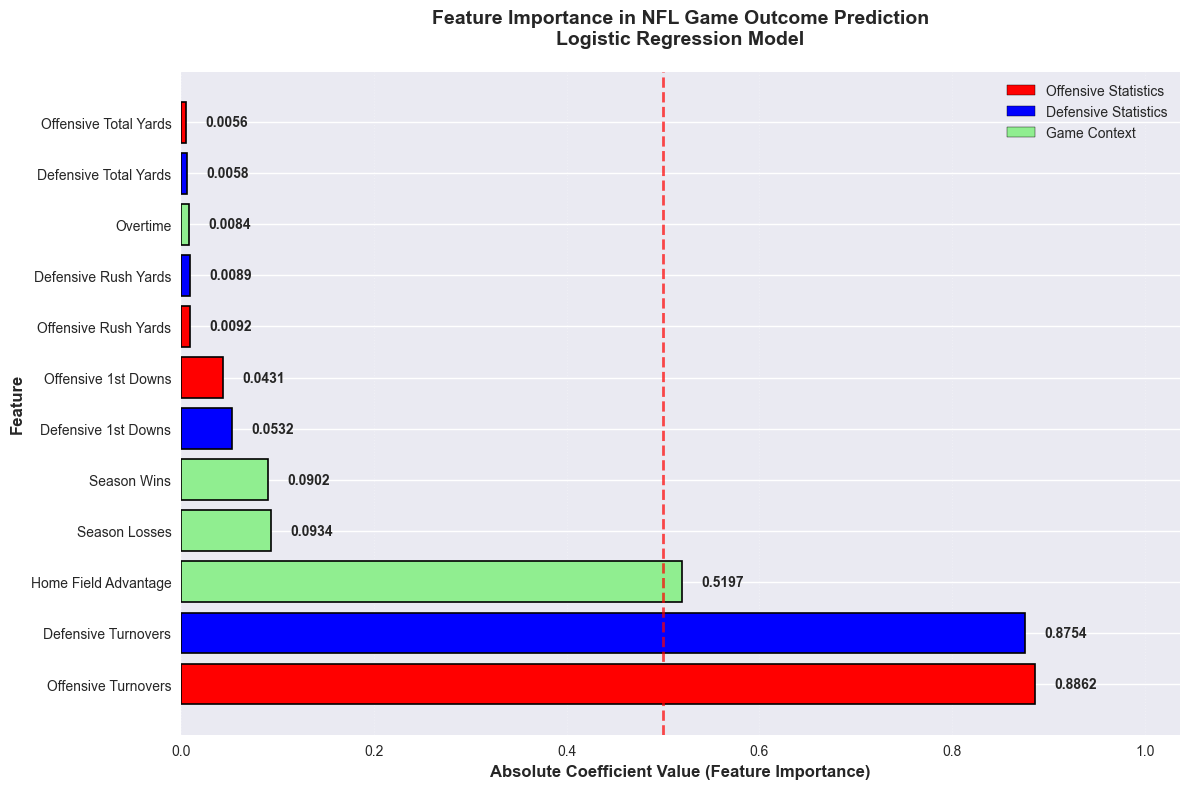

In [ ]:
# Define figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for categories
category_colors = {
    'Offensive': 'red',
    'Defensive': 'blue',
    'Contextual': 'lightgreen'
}

colors = feature_importance['Category'].map(category_colors)

# Create horizontal bar plot
bars = ax.barh(
    y=feature_importance['Feature_Label'],
    width = feature_importance['Abs_Coefficient'],
    color=colors,
    edgecolor='black',
    linewidth=1.2
)

# Add coefficient values at the end of each bar
for i, (idx, row) in enumerate(feature_importance.iterrows()):
    ax.text(
        row['Abs_Coefficient'] + 0.02,
        i,
        f"{row['Abs_Coefficient']:.4f}",
        va='center',
        fontsize=10,
        fontweight='bold'
    )

# Set labels and title
ax.set_xlabel('Absolute Coefficient Value (Feature Importance)', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance in NFL Game Outcome Prediction\nLogistic Regression Model',
            fontsize=14, fontweight='bold', pad=20)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=category_colors['Offensive'], edgecolor='black', label='Offensive Statistics'),
    Patch(facecolor=category_colors['Defensive'], edgecolor='black', label='Defensive Statistics'),
    Patch(facecolor=category_colors['Contextual'], edgecolor='black', label='Game Context')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

# Add a vertical line to show the where high impact features start
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='High Impact Threshold')

# # Adjust layout and grid
ax.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.8)
ax.set_xlim(0, max(feature_importance['Abs_Coefficient']) + 0.15)

plt.tight_layout()
plt.show()

### Visualization Analysis

This horizontal bar chart shows us exactly which features are most important. Turnovers have a significant lead on the rest of the features. The next three most important features are followed by contextual features including home field advantage and the number of wins and losses on the season. The rest of the feature start to become less significant, yet shoulnd't be completley overlooked. We also deemed a high value feature as having an absolute coefficient value as greater than 0.5 which we displayed with the dotted red line. Only offensive turnovers, defensive turnovers and home field advantage meet this criteria.

# 7) Insights and Conclusions

After reading through the notebook an uninformed reader would defintley feel informed about this topic. Although the main idea of this was to create a model to predict the outcome of nfl games even a less experienced individual could gain a lot of knowledge just from reading it over. For example, our data exploration and primary analysis identify some of the key aspects of a football game and what determines a team to win or lose the game. We need then make this easier to digest with our visualization section so the reader clearly knows which features are truly important when picking a winner or loser regardless if they even run the model themselves.

A reader who already knew about this topic would also be informed. Since they would already be equipped with the basic knowledges of the game and understand the different parts of the game intuivitley they could dive deeper into the actual work we did to get these outcomes. They would be able to statistically confirm their conventional knowledge about the game, like the importance of turnovers and home field advantage.